In [2]:
import librosa
import json
import math
import scipy
import statistics
import librosa.display
import scipy as sp
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns 

from sklearn.cluster import DBSCAN, KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [ ]:
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename

In [7]:


Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

C:/Users/urgpa/OneDrive/Escritorio/Unity/PuppetTest/Assets/_Sonidos/pana_miguel.wav


# LOAD SONG

In [3]:
file_dir = r"C:\Users\urgpa\OneDrive\Escritorio\Unity\PuppetTest\Assets\_Sonidos\warni.wav"
#ipd.Audio(file_dir)

In [4]:
signal, samplerate = librosa.load(file_dir)
#print(signal, samplerate)

# GET GENERAL SONG FEATURES

PREDICT SONG TEMPO

In [5]:
signal_bpm, samplerate_bpm = librosa.load(file_dir, duration = 30, sr = 10000)
onset_env = librosa.onset.onset_strength(signal_bpm, sr=samplerate_bpm)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=samplerate_bpm)
tempo

C:\Users\urgpa\anaconda3\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


array([146.484375])

# DIVIDE SONG INTO COMPASES

In [6]:
song_duration= librosa.get_duration(y=signal, sr=samplerate) #duration of the song

beat_num = 1
bpm = tempo
vcompas_time = beat_num * 60 / bpm #duration of a compas
                                       
vcompas_num  = song_duration / vcompas_time                  #number of compases 
compas_sample_num = vcompas_time * samplerate                #number of samples on each compas
song_sample_num = compas_sample_num * vcompas_num            #total number of samples in the song


vcompas_data = {} 
for vcompas_i in range(0,int(vcompas_num)):                                
    start = math.floor(compas_sample_num * vcompas_i)          #start sample for the compas
    end = math.floor(compas_sample_num * (vcompas_i + 1))      #end sample for the compas
    selected_samples = signal[start:end]                       #array with all the compas samples
    vcompas_data[vcompas_i] = ([selected_samples],vcompas_time * vcompas_i)

df_compas = pd.DataFrame.from_dict(vcompas_data, orient = 'index', columns = ['wform','times'])

# GET COMPAS BIGGEST FREQUENCIES

In [7]:
#CREATE A DATA FRAME WITH THE FREQUENCIES ARRAY
df_freq = pd.DataFrame(columns = ['mag']) 
for csignal in df_compas['wform']:
    csignal = csignal[0]
    X = np.fft.fft(csignal)
    X_mag = np.absolute(X)
    #print(X_mag[0])
    newdf = pd.DataFrame([[X_mag]], columns = ['mag'])
    df_freq = pd.concat([df_freq, newdf], axis = 0)

df_freq = df_freq.reset_index(drop = True)

In [8]:
#GET MAXIMUS OF THE FREQUENCIES
instrument_division = [0,100,300,600,1000,2500,7000,15000]
fixed_instrument_div = list(instrument_division)
fixed_instrument_div.remove(0)

f = np.linspace(0, samplerate, len(X_mag), endpoint = False)
df_bin_freq = pd.DataFrame(columns = fixed_instrument_div)

for ampl in df_freq.mag: #loop time domain compases
    
    freq_full = [] #list with al freq list

    for i in range(1,len(instrument_division)): #loop through freq domain
        
        start = instrument_division[i - 1] * len(ampl) / f[len(ampl) - 2] #starting point of the frequency bin
        end = instrument_division[i] * len(ampl) / f[len(ampl) - 2] #end point
        
        freq_bin = ampl[math.floor(start):math.floor(end)] #save magintudes bin
        freq_full += [freq_bin]
        #print(freq_bin)
        #dat_tuple = (list(ampl).index(ampl[start:end].max()),signl[start:end].max())
        #print(f[dat_tuple[0]], dat_tuple)

    newdf_cluster_freq = pd.DataFrame([freq_full], columns = fixed_instrument_div)
    df_bin_freq = pd.concat([df_bin_freq, newdf_cluster_freq])
    
df_bin_freq = df_bin_freq.reset_index()
df_bin_freq.drop(['index'], inplace = True, axis = 1)

# LOWER FREQS

In [9]:
df_lower = df_bin_freq.drop(columns = [600,1000,2500,7000,15000])
df_lower.columns = list(map(lambda x: str(x), df_lower.columns))

In [10]:
df_lower['100_mean'] = df_lower['100'].apply(lambda x: x.mean())
df_lower['100_median'] = df_lower['100'].apply(lambda x: statistics.median(x))
df_lower['100_max'] = df_lower['100'].apply(lambda x: x.max())
df_lower['300_mean'] = df_lower['300'].apply(lambda x: x.mean())
df_lower['300_median'] = df_lower['300'].apply(lambda x: statistics.median(x))
df_lower['300_max'] = df_lower['300'].apply(lambda x: x.max())

In [11]:
df_lower_model = df_lower.drop(['100','300'], axis = 1)

In [12]:
scaler = StandardScaler().fit(df_lower_model)
X_prep = scaler.transform(df_lower_model)

kmeans = GaussianMixture(n_components= 2, covariance_type='diag',max_iter =  100,n_init = 8, random_state = 1234)
kmeans.fit(X_prep)

yhat = kmeans.predict(X_prep)
clusters = np.unique(yhat)

In [13]:
df_low_final = df_compas.drop(columns = ['wform'])
df_low_final['times'] = df_low_final['times'].apply(lambda x: x[0])
df_low_final['gnre'] = yhat
df_low_final

,times,gnre
0,0.0000,1
1,0.4096,1
2,0.8192,1
3,1.2288,1
4,1.6384,1
...,...,...
1043,427.2128,1
1044,427.6224,1
1045,428.0320,1
1046,428.4416,1


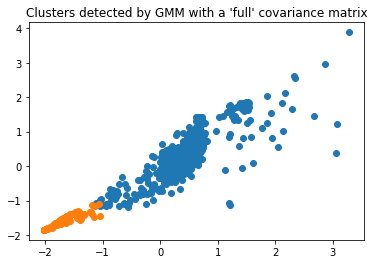

In [14]:
# create scatter plot for samples from each cluster
for cluster in np.unique(yhat):
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X_prep[row_ix, 0], X_prep[row_ix, 1])

# show the plot
plt.title("Clusters detected by GMM with a 'full' covariance matrix")
plt.show()

# MID FREQS

In [15]:
#get the specific bin frequencies
df_mid = df_bin_freq.drop(columns = [100,300,2500,7000,15000])
df_mid.columns = list(map(lambda x: str(x), df_mid.columns))

In [16]:
df_mid['600_mean'] = df_mid['600'].apply(lambda x: x.mean())
df_mid['600_median'] = df_mid['600'].apply(lambda x: statistics.median(x))
df_mid['600_max'] = df_mid['600'].apply(lambda x: x.max())
df_mid['1000_mean'] = df_mid['1000'].apply(lambda x: x.mean())
df_mid['1000_median'] = df_mid['1000'].apply(lambda x: statistics.median(x))
df_mid['1000_max'] = df_mid['1000'].apply(lambda x: x.max())

In [17]:
df_mid_model = df_mid.drop(['600','1000'], axis = 1)

In [18]:
scaler = StandardScaler().fit(df_mid_model)
X_prep = scaler.transform(df_mid_model)

kmeans = GaussianMixture(n_components= 2, covariance_type='spherical',max_iter = 300,n_init = 8, random_state = 1234, init_params = 'random')
#kmeans = KMeans(n_clusters= 2,
 #               init="random",
  #              n_init= 20,  # try with 1, 4, 8, 20, 30, 100...
   ##             max_iter= 200,
     #           tol= 1e-4,
      ##          algorithm="auto",
        #        random_state=1234)

kmeans.fit(X_prep)

yhat = kmeans.predict(X_prep)
clusters = np.unique(yhat)

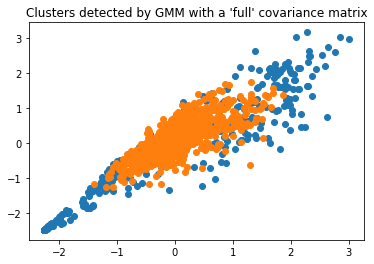

In [19]:
# create scatter plot for samples from each cluster
for cluster in np.unique(yhat):
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X_prep[row_ix, 0], X_prep[row_ix, 1])

# show the plot
plt.title("Clusters detected by GMM with a 'full' covariance matrix")
plt.show()

In [20]:
df_mid_final = df_compas.drop(columns = ['wform'])
df_mid_final['times'] = df_mid_final['times'].apply(lambda x: x[0])
df_mid_final['gnre'] = yhat
df_mid_final

,times,gnre
0,0.0000,0
1,0.4096,0
2,0.8192,0
3,1.2288,0
4,1.6384,0
...,...,...
1043,427.2128,0
1044,427.6224,0
1045,428.0320,0
1046,428.4416,0


# HIGH FREQUENCIES

In [21]:
#get the specific bin frequencies
df_high = df_bin_freq.drop(columns = [100,300,600,1000])
df_high.columns = list(map(lambda x: str(x), df_high.columns))

In [22]:
df_high['2500_mean'] = df_high['2500'].apply(lambda x: x.mean())
df_high['2500_median'] = df_high['2500'].apply(lambda x: statistics.median(x))
df_high['2500_max'] = df_high['2500'].apply(lambda x: x.max())
df_high['7000_mean'] = df_high['7000'].apply(lambda x: x.mean())
df_high['7000_median'] = df_high['7000'].apply(lambda x: statistics.median(x))
df_high['7000_max'] = df_high['7000'].apply(lambda x: x.max())
df_high['15000_mean'] = df_high['15000'].apply(lambda x: x.mean())
df_high['15000_median'] = df_high['15000'].apply(lambda x: statistics.median(x))
df_high['15000_max'] = df_high['15000'].apply(lambda x: x.max())

In [23]:
df_high_model = df_high.drop(['2500','7000','15000'], axis = 1)

In [24]:
scaler = StandardScaler().fit(df_mid_model)
X_prep = scaler.transform(df_mid_model)

kmeans = GaussianMixture(n_components= 4, covariance_type='spherical',max_iter = 100,n_init = 20, random_state = 1234, init_params = 'kmeans')

#kmeans = KMeans(n_clusters= 2,
#               init="random",
#               n_init= 1,  # try with 1, 4, 8, 20, 30, 100...
#               max_iter= 300,
#               tol= 1e-4,
#               algorithm="elkan",
#               random_state=1234)

kmeans.fit(X_prep)

yhat = kmeans.predict(X_prep)
clusters = np.unique(yhat)

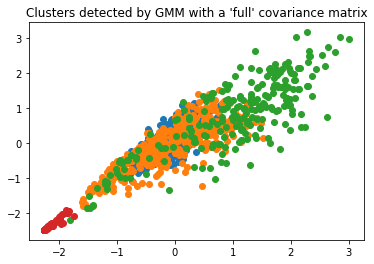

In [25]:
for cluster in np.unique(yhat):
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X_prep[row_ix, 0], X_prep[row_ix, 1])

# show the plot
plt.title("Clusters detected by GMM with a 'full' covariance matrix")
plt.show()

In [26]:
df_high_final = df_compas.drop(columns = ['wform'])
df_high_final['times'] = df_high_final['times'].apply(lambda x: x[0])
df_high_final['gnre'] = yhat
df_high_final

,times,gnre
0,0.0000,3
1,0.4096,3
2,0.8192,3
3,1.2288,2
4,1.6384,2
...,...,...
1043,427.2128,3
1044,427.6224,3
1045,428.0320,3
1046,428.4416,3


# FULL SONG VALUES

In [27]:
full_freq = pd.concat([df_high_model, df_mid_model, df_lower_model], axis = 1)

In [28]:
scaler = StandardScaler().fit(full_freq)
X_prep = scaler.transform(full_freq)

#kmeans = GaussianMixture(n_components= 3, covariance_type='spherical',max_iter = 100,n_init = 10, random_state = 1234, init_params = 'random')

kmeans = KMeans(n_clusters= 3,
               init="random",
               n_init= 2,  # try with 1, 4, 8, 20, 30, 100...
               max_iter= 300,
               tol= 1e-4,
               algorithm="auto",
               random_state=1234)

kmeans.fit(X_prep)

yhat = kmeans.predict(X_prep)
clusters = np.unique(yhat)

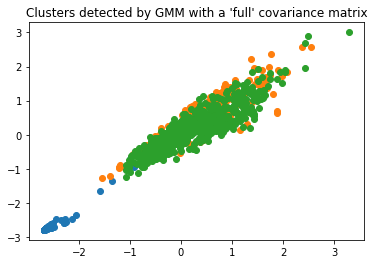

In [29]:
for cluster in np.unique(yhat):
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X_prep[row_ix, 0], X_prep[row_ix, 1])

# show the plot
plt.title("Clusters detected by GMM with a 'full' covariance matrix")
plt.show()

In [30]:
df_full_final = df_compas.drop(columns = ['wform'])
df_full_final['times'] = df_full_final['times'].apply(lambda x: x[0])
df_full_final['gnre'] = yhat
df_full_final

,times,gnre
0,0.0000,0
1,0.4096,0
2,0.8192,0
3,1.2288,0
4,1.6384,0
...,...,...
1043,427.2128,0
1044,427.6224,0
1045,428.0320,0
1046,428.4416,0


# SONG FEATURES

In [31]:
#menas = []
#for index in range(len(df_compas.wform)):
#    y_harm, y_perc = librosa.effects.hpss(df_compas.wform[index][0])
#    if len(y_harm[y_perc > 0.1]) > 0:
#        menas += [(y_harm[y_perc > 0.1].max() * len(y_harm[y_perc > 0.1]))]
#df = pd.DataFrame(menas).dropna()

In [32]:
#mean_harm = df[0].mean()

In [33]:
step_freq = 1/(vcompas_time * 2)
noise_freq = 1/(vcompas_time * 2)
#constant_noise_rot = 0.16688923225825697
#constant_noise_pos = 0.0018604045563215532

#noise_pos = constant_noise_pos * mean_harm
#noise_rot = constant_noise_rot * mean_harm
#print(noise_pos,noise_rot)

# SAVING DATA INTO JSON

In [34]:
dict_full = {}
dict_low = {}
dict_mid = {}
dict_high = {}
dict_legs = {}

for i in range(0,len(df_low_final.times)):
    dict_low[str(df_low_final.times[i])] = str(df_low_final.gnre[i])
    dict_mid[str(df_mid_final.times[i])] = str(df_mid_final.gnre[i])
    dict_high[str(df_high_final.times[i])] = str(df_high_final.gnre[i])
    dict_legs[str(df_full_final.times[i])] = str(df_full_final.gnre[i])

dict_full['low'] = str(dict_low)
dict_full['mid'] = str(dict_mid)
dict_full['high'] = str(dict_high)
dict_full['legs'] = str(dict_legs)
dict_full['freqs'] = str(step_freq[0])

In [35]:
json_dump = json.dumps(dict_full)

print(json_dump)

{"low": "{'0.0': '1', '0.4096': '1', '0.8192': '1', '1.2288000000000001': '1', '1.6384': '1', '2.048': '1', '2.4576000000000002': '1', '2.8672': '1', '3.2768': '1', '3.6864000000000003': '1', '4.096': '1', '4.5056': '1', '4.9152000000000005': '1', '5.324800000000001': '1', '5.7344': '1', '6.144': '1', '6.5536': '1', '6.9632000000000005': '1', '7.372800000000001': '0', '7.7824': '1', '8.192': '1', '8.601600000000001': '1', '9.0112': '0', '9.4208': '0', '9.830400000000001': '1', '10.24': '1', '10.649600000000001': '1', '11.0592': '0', '11.4688': '1', '11.878400000000001': '1', '12.288': '1', '12.697600000000001': '0', '13.1072': '1', '13.5168': '1', '13.926400000000001': '1', '14.336': '0', '14.745600000000001': '0', '15.1552': '0', '15.5648': '0', '15.974400000000001': '0', '16.384': '0', '16.7936': '0', '17.203200000000002': '0', '17.6128': '0', '18.0224': '0', '18.432000000000002': '0', '18.8416': '0', '19.2512': '0', '19.660800000000002': '0', '20.0704': '0', '20.48': '0', '20.8896':

In [36]:
with open('../json/poses.json', 'w') as f:
    f.write(json_dump)
with open(r'C:\Users\urgpa\OneDrive\Escritorio\Unity\PuppetTest\Assets\_Scripts\Poses\poses.json', 'w') as f:
    f.write(json_dump)

# PLOTTING

In [1467]:
def plot_mono_ham_perc():
    inp = int(input())
    index = inp / int(vcompas_time)
    
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

    librosa.display.waveplot(df_compas.wform[index][0], sr=samplerate, ax=ax[0])
    ax[0].set(title='Monophonic')
    ax[0].label_outer()

    y_harm, y_perc = librosa.effects.hpss(df_compas.wform[index][0])
    print(y_harm[y_perc > 0.1].mean() * len(y_harm[y_perc > 0.1]))
    librosa.display.waveplot(y_harm, sr=samplerate, alpha=0.25, ax=ax[1])
    librosa.display.waveplot(y_perc, sr=samplerate, color='r', alpha=0.5, ax=ax[1])
    ax[1].set(title='Harmonic + Percussive')

plot_mono_ham_perc()

10


ZeroDivisionError: division by zero

10


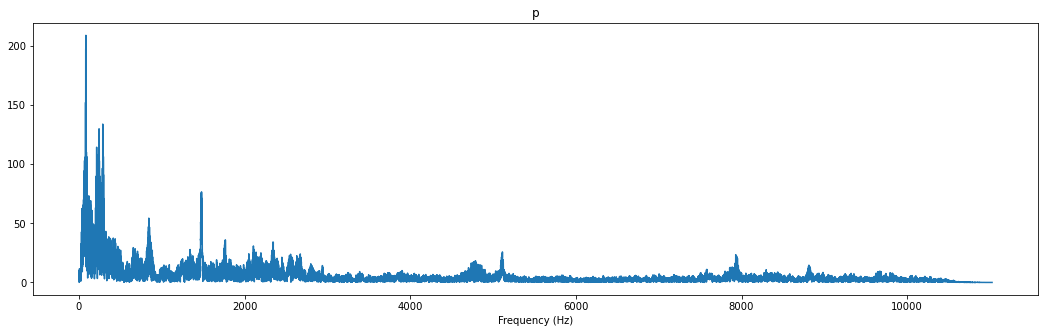

In [16]:
def plot_magnitude_spectrum(sr, title, f_ratio=0.5):
    index = int(input())
    #index = inp / vcompas_time
    signal = df_compas.wform[index][0]
    
    y_harm, y_perc = librosa.effects.hpss(signal)
    
    psignal = np.array(0)
    if title[0].lower() == 'h':
        psignal = y_harm
    elif title[0].lower() == 'p':
        psignal = y_perc
    else:
        psignal = signal
    
    X = np.fft.fft(psignal)
    X_mag = np.absolute(X)
    
    plt.figure(figsize=(18, 5))
    
    f = np.linspace(0, samplerate, len(X_mag), endpoint = False)
    f_bins = int(len(X_mag)*f_ratio)  
    
    plt.plot(f[:f_bins], X_mag[:f_bins])
    plt.xlabel('Frequency (Hz)')
    plt.title(title)

plot_magnitude_spectrum(samplerate, 'p', 0.5)

In [22]:
f = np.linspace(0, samplerate, len(X_mag), endpoint = False)

In [28]:
list(f).index(1000)

30000

In [24]:
len(f)

44100

In [34]:
list(f).index(samplerate)

ValueError: 22050 is not in list

In [35]:
f[len(signl)]

IndexError: index 44100 is out of bounds for axis 0 with size 44100